In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold,\
StratifiedKFold,cross_val_score

from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

## 1) Load the dataset into python environment

In [3]:
titanic = pd.read_csv('/content/titanic_dataset_1.csv')
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
# Rearranging the columns

titanic = titanic[['PassengerId', 'Name',
    'Sex', 'Age', 'SibSp','Parch', 'Pclass',
    'Ticket', 'Cabin', 'Fare',
    'Embarked', 'Survived']]

## 2) Do all the necessary pre-processing steps

In [8]:
titanic = titanic.drop(['PassengerId','Ticket'],axis=1)

In [9]:
# Getting a copy of cabin to perform analysis
cabin = titanic[['Cabin']].copy()

# Getting the data of 'Deck'
cabin["Cabin_Data"] = cabin["Cabin"].isnull().apply(lambda x: not x)
cabin["Deck"] = cabin["Cabin"].str.slice(0,1)

# Getting the data of 'Room'
cabin["Room"] = cabin["Cabin"].str.slice(1,5).str.extract(
    "([0-9]+)", expand=False).astype("float")

# Fill the 'NA' values
cabin['Deck'] = cabin['Deck'].fillna('N')
cabin["Room"] = cabin["Room"].fillna(cabin["Room"].mean())

# Dropping unnecessary columns
cabin.drop(['Cabin','Cabin_Data'],axis=1,inplace=True)

# Embedding
titanic[['Deck','Room']] = cabin[['Deck','Room']]

del cabin

In [10]:
#Extracting Data From the 'Family' column

titanic['Family_Onboard'] = (titanic
 ['SibSp'] + titanic['Parch']+1).astype(int)
titanic = titanic.drop(['SibSp','Parch'],axis=1)

In [11]:
#Extracting Data From the 'Name' column

titanic['Title'] = titanic.Name.str.extract(
    ' ([A-Za-z]+)\.',expand=False)

titanic['Title'] = titanic['Title'].replace(
    ['Ms','Mlle'],'Miss')
titanic['Title'] = titanic['Title'].replace(
    ['Mme'],'Mrs')

titanic['Title'] = titanic['Title'].replace(
    ['Don', 'Rev', 'Dr', 'Major', 'Lady',
       'Sir', 'Col', 'Capt', 'Countess',
      'Jonkheer'],'Others')

titanic = titanic.drop('Name',axis=1)

In [12]:
#rearranging the columns

titanic = titanic[['Title', 'Sex', 'Age',
    'Family_Onboard','Pclass','Deck',
    'Room','Fare', 'Embarked', 'Survived']]

titanic.head(1)

,Title,Sex,Age,Family_Onboard,Pclass,Deck,Room,Fare,Embarked,Survived
0,Mr,male,22.0,2,3,N,50.49,7.25,S,0


In [13]:
#Filling with Zeroes and Null Values

missing_values = titanic.isnull().sum()
missing_values[missing_values>0]/len(titanic)*100


Age         19.865320
Embarked     0.224467
dtype: float64

<Axes: >

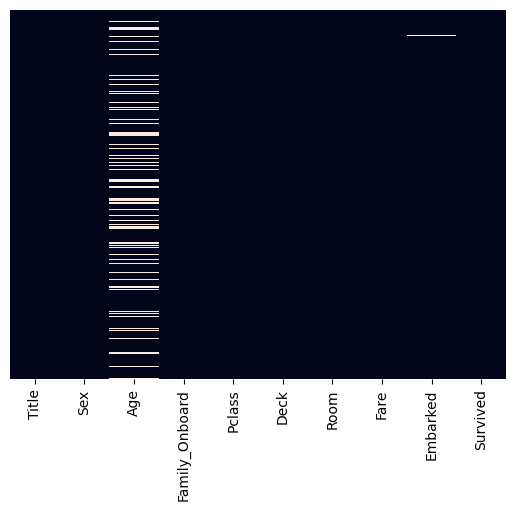

In [14]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False)

In [15]:
impute = float(titanic['Age'].median())
titanic['Age'].fillna(impute, inplace= True)

Only three values embedded in the Embarked column therefore most suitable would be the most frequent one, which can code with mode( )

In [16]:
impute = titanic['Embarked'].mode()[0]
titanic['Embarked'].fillna(impute, inplace= True)

### Handling Outliers

Text(0.5, 1.0, 'Before Removing Outliers')

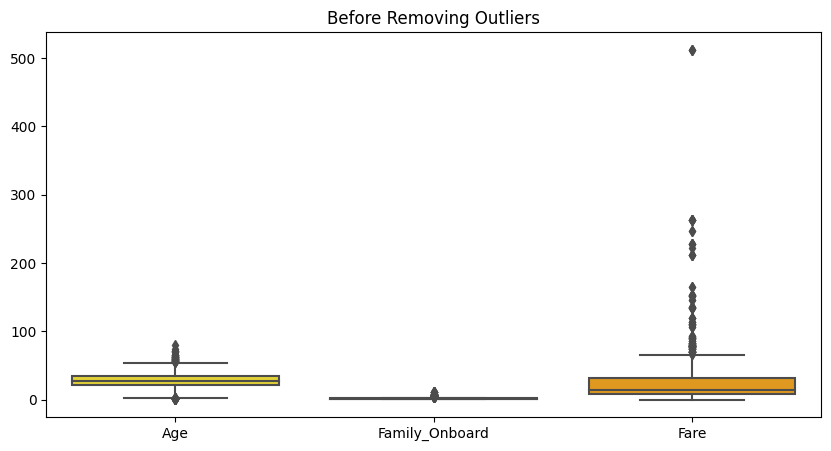

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(titanic[['Age',
      'Family_Onboard','Fare']]
        ,palette='Wistia')
plt.title("Before Removing Outliers")

In [24]:
# creating function to find the outliers

def outlier(col):
  c = 1.5

  IQR = ((np.quantile(titanic[col],0.75))-
  (np.quantile(titanic[col],0.25)))

  Max = (np.quantile(titanic[col],0.75)) + c*IQR
  Min = (np.quantile(titanic[col],0.25)) - c*IQR

  df = titanic[(titanic[col] > Max) | (titanic[col] < Min)]

  return df

In [29]:
# Imputation and Caping to reduce outliers

columns = ('Age','Family_Onboard','Fare')

for key in columns:
  out = outlier(key)
  for i in out.index:
    titanic.loc[i,key] = np.nan

titanic['Age'].fillna(titanic['Age'].mean(),inplace=True)
titanic['Family_Onboard'].fillna(
    titanic['Family_Onboard'].mean(),inplace=True)
titanic['Fare'].fillna(titanic['Fare'].mean(),inplace=True)

Text(0.5, 1.0, 'After Removing Outliers')

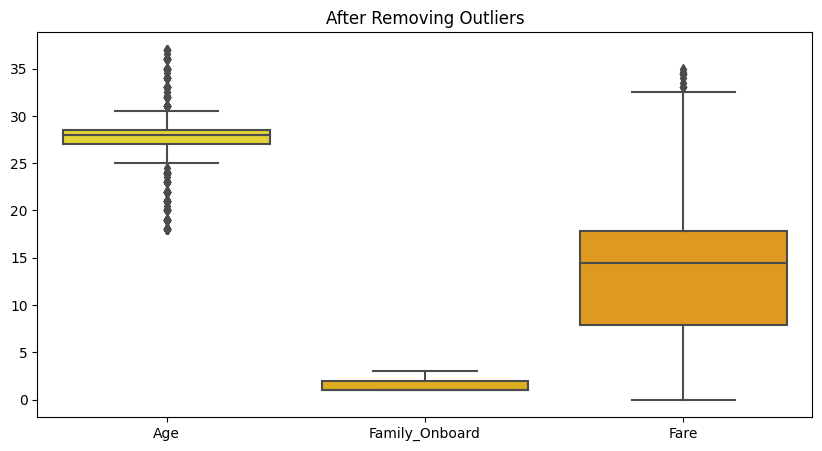

In [31]:
plt.figure(figsize=(10,5))
sns.boxplot(titanic[['Age','Family_Onboard','Fare']],palette='Wistia')
plt.title("After Removing Outliers")

### Encoding Categorical Values

In [32]:
sex_en = {'male':0,'female':1}
titanic['Sex'] = titanic['Sex'].replace(sex_en)

title_en = {'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Others':4}
titanic['Title'] = titanic['Title'].replace(title_en)

emb_en = {'S':0,'C':1,'Q':2}
titanic['Embarked'] = titanic['Embarked'].replace(emb_en)

dk_en = LabelEncoder().fit_transform(titanic['Deck'])
titanic['Deck'] = pd.DataFrame(dk_en,columns=['Deck'])

titanic.head(3)

,Title,Sex,Age,Family_Onboard,Pclass,Deck,Room,Fare,Embarked,Survived
0,0,0,22.000000,2.0,3,7,50.49,7.250000,0,0
1,1,1,27.356536,2.0,1,2,85.00,17.822091,1,1
2,2,1,26.000000,1.0,3,7,50.49,7.925000,0,1


In [33]:
#Scaling On Necessary Columns

std = Normalizer().fit_transform(titanic[['Age','Fare','Room']])

scaled = pd.DataFrame(std,columns=['Age','Fare','Room'])

titanic['Age'] = scaled['Age']
titanic['Fare'] = scaled['Fare']
titanic['Room'] = scaled['Room']

titanic.head(3)

,Title,Sex,Age,Family_Onboard,Pclass,Deck,Room,Fare,Embarked,Survived
0,0,0,0.396040,2.0,3,7,0.908911,0.130513,0,0
1,1,1,0.300440,2.0,1,2,0.933502,0.195729,1,1
2,2,1,0.453424,1.0,3,7,0.880514,0.138207,0,1


# 3) Create kNN and SVM models

In [34]:
x = titanic.iloc[:,0:-1]
y = titanic.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(
    x,y,random_state=91, test_size=0.1)

In [35]:
#K-Nearest Neighbors Classifiers

knn_classifier = KNeighborsClassifier(n_neighbors=2).fit(x_train,y_train)
knn_score = knn_classifier.score(x_test,y_test)
print(f'KNN Accuracy Score: {knn_score*100:.2f}%')

k_fold = KFold(n_splits = 3,random_state = 8, shuffle=True)
kfold_result = cross_val_score(knn_classifier,x,y,cv=k_fold)
print(f'KNN Accuracy Score with KFold CV: {kfold_result.mean()*100:.2f}%')

sk_fold = StratifiedKFold(n_splits = 4 ,random_state = 0, shuffle=True)
skfold_result = cross_val_score(knn_classifier,x,y,cv=sk_fold)
print(f'KNN Accuracy Score with Stratified CV: {skfold_result.mean()*100:.2f}%')


KNN Accuracy Score: 84.44%
KNN Accuracy Score with KFold CV: 79.69%
KNN Accuracy Score with Stratified CV: 80.92%


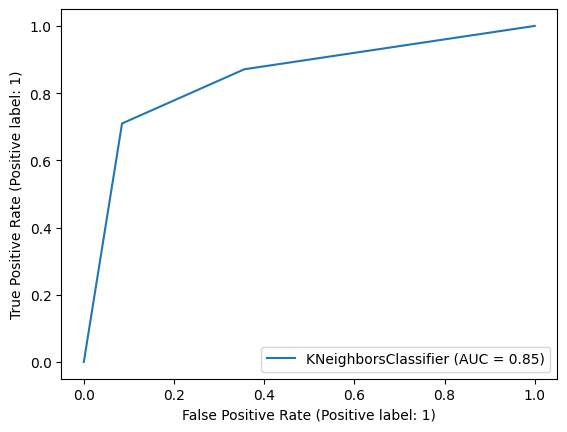

In [36]:
svc_disp = RocCurveDisplay.from_estimator(knn_classifier, x_test, y_test)

In [37]:
#Support Vector Classifiers

svm_classifier = SVC(C=34, random_state=0,
          probability=True).fit(x_train,y_train)
svm_score = svm_classifier.score(x_test,y_test)
print(f'SVC Accuracy Score:{svm_score*100:.2f}%')

svc_fold = KFold(n_splits = 9,random_state = 18,
                 shuffle=True)
svc_fold_result = cross_val_score(svm_classifier,
                                  x,y,cv=svc_fold)
print(f'SVC Accuracy Score with KFold CV:{svc_fold_result.mean()*100:.2f}%')

svc_sfold = StratifiedKFold(n_splits = 22,random_state = 30, shuffle=True)
svc_sfold_result = cross_val_score(svm_classifier,x,y,cv=svc_sfold)
print(f'SVC Accuracy Score with Stratified CV:{svc_sfold_result.mean()*100:.2f}%')

SVC Accuracy Score:86.67%
SVC Accuracy Score with KFold CV:83.39%
SVC Accuracy Score with Stratified CV:82.95%


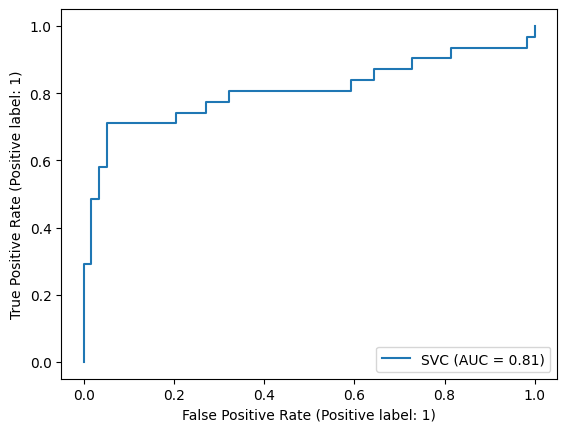

In [38]:
svc_disp = RocCurveDisplay.from_estimator(svm_classifier, x_test, y_test)

# 4) Evaluation

The result shows that SVC performed better than  KNN algorithm.